In [73]:
# Dependencies

# Statistics modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Regression models
import scipy.stats as stats
from sklearn import datasets, linear_model
from sklearn.feature_selection import chi2, f_regression
from sklearn.metrics import mean_squared_error, r2_score


# Census module
from census import Census
from us import states
from config import akey
c = Census(akey)

# JSON requests module
import requests

# Plotting modules
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = 20, 15

import warnings
warnings.filterwarnings('ignore')

In [74]:
# Import Sports Data of each organization and normalize datatypes so they are easier to compare against future dataframes.

mlb_data_file = "Resources/mlb.csv"
mlb_locations_file = "Resources/mlb_loc.csv"
mlb_df = pd.read_csv(mlb_data_file, low_memory = False)
mlb_locations_df = pd.read_csv(mlb_locations_file, dtype = {'State Name': 'str',
                                                              'MLB Team(s)': 'str',
                                                              'stadium_zipcode': 'str',
                                                              'organizatin': 'str'},low_memory = False) 

nfl_data_file = "Resources/nfl.csv"
nfl_locations_file = "Resources/nfl_loc.csv"
nfl_df = pd.read_csv(nfl_data_file, low_memory = False)
nfl_location_df = pd.read_csv(nfl_locations_file, dtype = {'State Name':'str',
                                                          'NFL Teams':'str',
                                                          'Stadium City':'str',
                                                          'Zip Codes':'str'
                                                          ,'organization' : 'str'}, low_memory = False)

nba_data_file = "Resources/nba.csv"
nba_locations_file = "Resources/nba_loc.csv"
nba_df = pd.read_csv(nba_data_file, low_memory = False)
nba_locations_df = pd.read_csv(nba_locations_file,  dtype = {'State Name':'str',
                                                          'NBA Team(s)':'str',
                                                          'Stadium City':'str',
                                                          'zip_code':'str' ,
                                                          'organization' : 'str'}, low_memory = False)

In [75]:
# Create Functions of teams
def nfl_team(x):
   nfl_data=nfl_df[nfl_df["Tm"] == x].reset_index(drop=True)
   return(nfl_data)
def nba_team(x):
   nba_data=nba_df[nba_df["Team"]==x].reset_index(drop=True)
   return(nba_data)
def mlb_team(x):
   mlb_data=mlb_df[mlb_df['team']==x].reset_index(drop=True)
   return(mlb_data)

### Understanding the Census JSON
Many statistics that the Census reports on are not accessible from the `census` package. However, those reports have IDs similar to how `census` calls the ones it can. These can be seen and compared against using the UI found on [US Fact Finder](https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t). Here you can see the sets of reports available by id based off your selection. ACS 5-year estimates were used for the majority of this study, and can be filtered in the selection.

## Census JSON pages

The [Census Developer's Page](https://www.census.gov/data/developers/data-sets/acs-5year.html) shows how to make a JSON call to the different tables. Notice the addition of `subject?` to the subject table calls. This is essentially where the break from the `census` package occurs, and why not all tables can be called. These call urls are the crux of the data mining scripts to obtain census data.

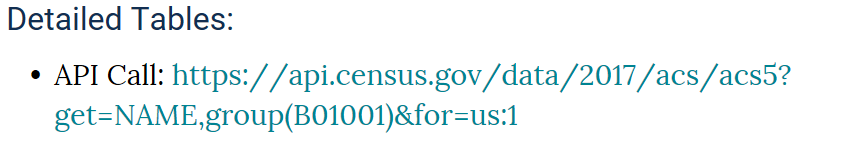
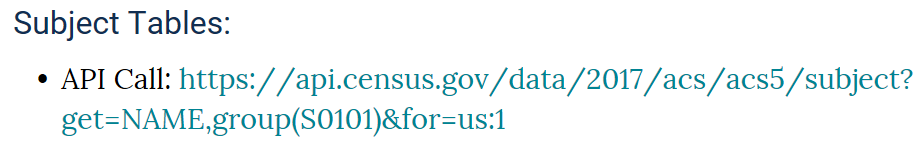


In [76]:
# urls of detailed & subject tables with example (not used)
url = 'https://api.census.gov/data/2016/acs/acs5/subject?get=NAME,S1902_C01_001E,S2409_C05_006E&for=zip%20code%20tabulation%20area:*'
urlg = 'https://api.census.gov/data/2017/acs/acs5?get=NAME,group(B01001)&for=us:1'

#url fixed variables
urlbeg = 'https://api.census.gov/data/'

urlmid = '/acs/acs5/subject?get=NAME,'
urlmidd = '/acs/acs5?get=NAME,'

urlend = '&for=zip%20code%20tabulation%20area:*'

# reports, while independently stored in list by name
#, are a single string within the call, notice the reports & reports names are in inverse order

reportsf = 'S1902_C01_001E,S2409_C05_006E,S1251_C01_001E,S2301_C01_001E,S1701_C01_001E'
reportsd = 'B01003_001E,B19013_001E,B19301_001E'
reportnames = ['PopInPoverty','PopEmployed','MarriedPastYr','PercentFemaleEmployed','EstMeanIncAll']
reportnamesd = ['Per Capita Income','Household Income','Population']



# The looped variable in the calls are the years
years = ['2016', '2017']

# Intialize empty lists to store call urls and json requests of reports by running a for loop appending each url in a string.

urlsf = [(urlbeg + year + urlmid + reportsf + urlend) for year in years]
urlsd = [(urlbeg + year + urlmidd + reportsd + urlend) for year in years]


# Reports Data variables import as a collection of reports elements per json url, where
# an independent list is a particular zip code's report metric

reports1 = [requests.get(url).json() for url in urlsf]
reports2 = [requests.get(url).json() for url in urlsd]
# Each url in urls corresponds to a year where each element is a zip, and each expression a metric of that report's metric
# for that zip
#
# Knowing this, we use the element of the year/url and loop through the range of those elements essentially creating a unique
# range of indexes grouped by (year, zip) expressed as that report metrics

    
df_full1 = pd.DataFrame()
for i, year in enumerate(years):
    df_one = pd.DataFrame([[g[6], g[5], g[4],g[3], g[2], g[1]] for g in reports1[i][1:]], columns = ['zip'] + reportnames)
    df_one['year'] = years[i]
    df_full1 = df_full1.append(df_one, ignore_index=True).reset_index(drop=True)

    
df_full2 = pd.DataFrame()
for i, year in enumerate(years):
    df_two = pd.DataFrame([[g[4], g[3], g[2], g[1]] for g in reports2[i][1:]], columns = ['zip'] + reportnamesd)
    df_two['year'] = years[i]
    df_full2 = df_full2.append(df_two, ignore_index=True).reset_index(drop=True)


In [77]:
df_full1.head()

,zip,PopInPoverty,PopEmployed,MarriedPastYr,PercentFemaleEmployed,EstMeanIncAll,year
0,01001,16706,14526,None,53.7,7190,2016
1,01002,24777,26811,None,50.6,9561,2016
2,01003,64,11296,None,-666666666.0,26,2016
3,01005,5122,4310,None,0.0,1840,2016
4,01007,14769,11838,None,64.8,5611,2016


In [120]:
df_full2.head()

,zip,Per Capita Income,Household Income,Population,year
0,01001,30430,56714,17423,2016
1,01002,26072,48923,29970,2016
2,01003,3829,2499,11296,2016
3,01005,32169,70568,5228,2016
4,01007,36359,80502,14888,2016


In [121]:
df_full1.EstMeanIncAll = df_full1.EstMeanIncAll.astype(int)

In [146]:
# Given that the sports data was type casted, perform same type castings for data merging & munging.

df_full1['zip'] = df_full1['zip'].astype('str')
df_full1['PopInPoverty'] = df_full1['PopInPoverty'].astype('int')
df_full1['PopEmployed'] = df_full1['PopEmployed'].astype('int')
df_full1['MarriedPastYr'] = df_full1['MarriedPastYr'].astype('str')
df_full1['EstMeanIncAll'] = df_full1['EstMeanIncAll'].astype('int')
df_full1['PercentFemaleEmployed'] = df_full1['PercentFemaleEmployed'].astype(float)


df_full2['zip'] = df_full2['zip'].astype('str')
df_full2['Per Capita Income'] = df_full2['Per Capita Income'].astype('str')
df_full2['Household Income'] = df_full2['Household Income'].astype('int')
df_full2['Population'] = df_full2['Population'].astype('int')


In [147]:
df_full2.dtypes

zip                  object
Per Capita Income    object
Household Income      int32
Population            int32
year                 object
dtype: object

In [148]:
# Since the Census data is grouped by Zip codes & year, the same is done with the sports organizations data, essentially
# giving each zip code a metric of team performance by year.

NFL_Full = pd.merge(nfl_location_df, nfl_df, left_on = 'NFL Team(s)', right_on = 'Tm' )
#NFL_Full.head()


#mlb_locations_df.head()
#mlb_df.head()
#MLB_Full = pd.merge(mlb_locations_df, mlb_df, left_on ='stadium_zipcode', right_on = 'zip')
#MLB_Full.head()

NBA_Full = pd.merge(nba_locations_df, nba_df, left_on = 'NBA Team(s)', right_on = 'Team')


In [133]:
# Since Performance is best identified a teams win-loss percentage, we create a slice of the fields that are important for
# comparison. These sets are then typecasted for data merging & comparison.

NFL_Sliced = NFL_Full[['year', 'NFL Team(s)', 'Zip Codes', 'W-L%']]
NFL_Sliced['W-L%']= NFL_Full['W-L%'].astype(float)
NFL_Sliced['year']= NFL_Full['year'].astype(str)
NFL_Sliced['W-L%']= NFL_Full['W-L%']*100


NBA_Sliced = NBA_Full[['year', 'NBA Team(s)', 'zip_code', 'W-L%']]
NBA_Sliced['W-L%']= NBA_Full['W-L%'].astype(float)
NBA_Sliced['year']= NBA_Full['year'].astype(str)
NBA_Sliced['W-L%']= NBA_Full['W-L%']*100


In [150]:
# The census dataframe is then merged against each organizations dataframe, by the year & zip as indexes.
# Null values are replaced.

NFLCensusDF= pd.merge(df_full1, NFL_Sliced, left_on = ['year','zip'], right_on = ['year','Zip Codes']).sort_values('EstMeanIncAll')
NFLCensusDF.loc[NFLCensusDF.PercentFemaleEmployed == -666666666.0, ['PercentFemaleEmployed']] = np.nan

NBACensusDF= pd.merge(df_full1, NBA_Sliced, left_on = ['year','zip'], right_on = ['year','zip_code']).sort_values('EstMeanIncAll')
NBACensusDF.loc[NBACensusDF.PercentFemaleEmployed == -666666666.0, ['PercentFemaleEmployed']] = np.nan


NFLCensusDF1= pd.merge(df_full2, NFL_Sliced, left_on = ['year','zip'], right_on = ['year','Zip Codes'])

NBACensusDF1= pd.merge(df_full2, NBA_Sliced, left_on = ['year','zip'], right_on = ['year','zip_code'])


In [158]:
# nfl_location_df['Zip Codes'] = nfl_location_df['Zip Codes'].astype('str')

# Later models will not work with null values, and those rows are dropped.
#NFLCensusDF = NFLCensusDF.dropna()
#NFLCensusDF = NFLCensusDF.reset_index(drop=True).head()

NBACensusDF = NBACensusDF.dropna()
NBACensusDF = NBACensusDF.reset_index(drop=True).head()
NBACensusDF1 = NBACensusDF1.dropna()
NBACensusDF1 = NBACensusDF1.reset_index(drop=True).head()

In [159]:
# As seen, each zip & year has a performance metric to be compared against the other census metric expressions.

NFLCensusDF1.head()

,zip,Per Capita Income,Household Income,Population,year,NFL Team(s),Zip Codes,W-L%
0,14127,45340,87369,30578,2016,Buffalo Bills,14127,43.8
1,15212,27573,40685,26331,2016,Pittsburgh Steelers,15212,68.8
2,19148,23012,46108,53870,2016,Philadelphia Eagles,19148,43.8
3,20785,29492,63704,37061,2016,Washington Redskins,20785,53.1
4,21230,44915,73203,34293,2016,Baltimore Ravens,21230,50.0


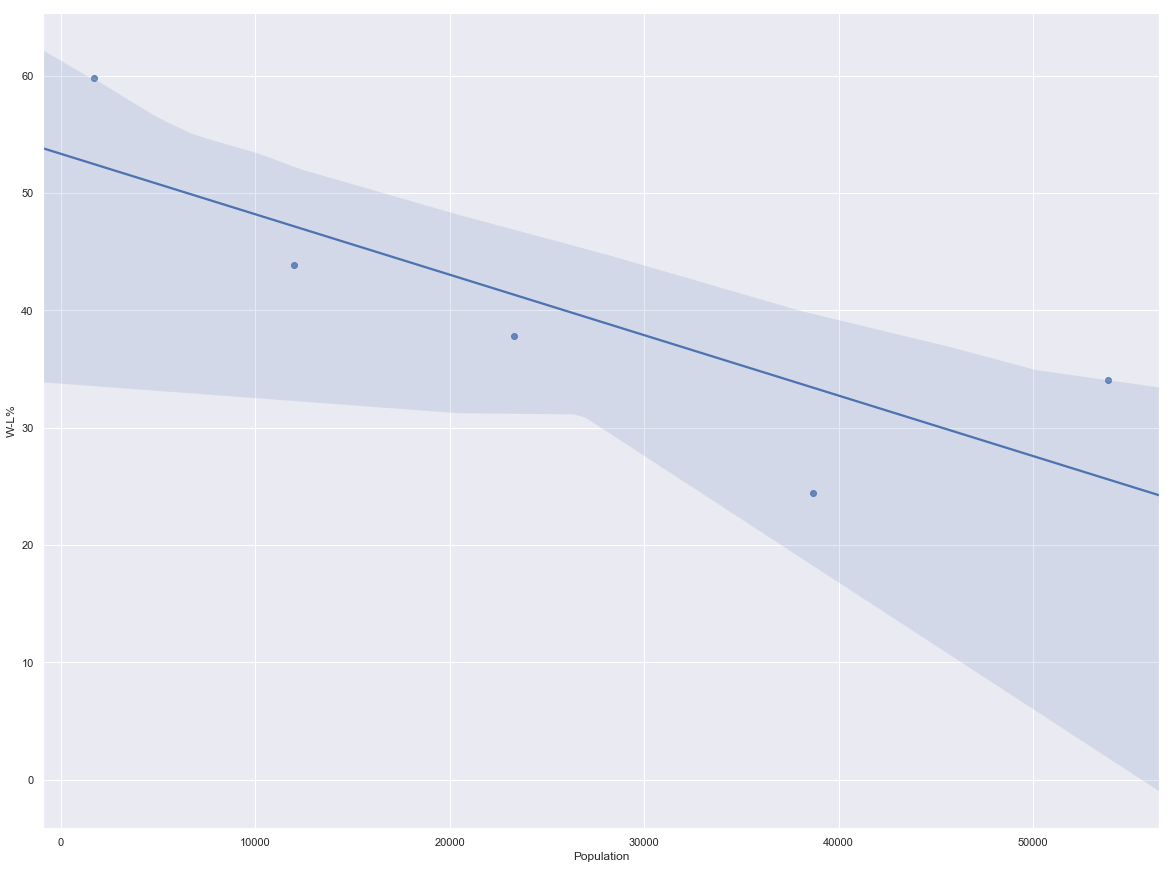

In [160]:
#sns.regplot(x="PercentFemaleEmployed", y="W-L%", data=NBACensusDF)
#sns.regplot(x="PopInPoverty", y="W-L%", data=NBACensusDF)
#sns.regplot(x="PopEmployed", y="W-L%", data=NBACensusDF)
#sns.regplot(x="MarriedPastYr", y="W-L%", data=NBACensusDF)
#sns.regplot(x="EstMeanIncAll", y="W-L%", data=NBACensusDF)
#sns.regplot(x="Household Income", y="W-L%", data=NBACensusDF1)
sns.regplot(x="Population", y="W-L%", data =NBACensusDF1)

In [142]:
x = NFLCensusDF['PercentFemaleEmployed'].values
x = x.reshape(-1,1)
y = NFLCensusDF['W-L%'].values
y = y.reshape(-1,1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
#scores, pvalues = chi2(x, y)
regression = f_regression(x,y,center=True)

print(regression)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [119]:
stats.f_oneway(x,y)

F_onewayResult(statistic=array([nan]), pvalue=array([nan]))